# Demo notebook for the Chung lab dataset

This notebook demonstrates how to retrieve volume data from the Kwanghun Chung lab's
[dandiset](https://gui.dandiarchive.org/#/dandiset/000108/draft). This dataset
is composed of ~2mm brain sections (slabs) imaged with a nuclear stain (YO),
a stain for NeuN (NN) and a stain for blood vessels (LEC). The tissue was
scanned on a light-sheet microscope that took consecutive stacks (chunks) scanning along the X
direction. The stacks were acquired to overlap by approximately 200 voxels in the
Y direction.

The data is organized into microscopy sessions, in which you will find the chunks and stains
for a given microscopy acquisition. The chunks are .h5 files that store a pyramid of 2x
downsampling: dataset "0" is the original, "1" is 2x downsampled, "2" is 4x downsampled, etc.
Each chunk has associated sidecar metadata which give the chunk extents and offsets. The
sidecar allows the various chunks to be stitched together to form the whole volume of
the slab.

See the function, "read", below for how to simply read an arbitrary subvolume with stitching.

In [1]:
from dandi.dandiapi import DandiAPIClient, RemoteDandiset
from dandi.exceptions import NotFoundError
import h5py
import hdf5plugin
from io import BytesIO
from matplotlib import pyplot, image
import numpy as np
from PIL import Image
import re
import requests
import typing
from urllib.parse import urlencode
from warnings import simplefilter
simplefilter("ignore")


In [2]:
ASSET_URL_DB = {}

def get_asset_url(dandiset, asset_id, version="draft"):
    """Return s3 url for a given asset id"""
    if asset_id not in ASSET_URL_DB:
        with DandiAPIClient.for_dandi_instance("dandi") as client:
            dandiset = client.get_dandiset(dandiset, version)
            asset = dandiset.get_asset(asset_id)
            try:
                asset_url = asset.get_content_url(r"s3\.amazonaws")
            except NotFoundError:
                return None
        ASSET_URL_DB[asset_id] = asset_url
    return ASSET_URL_DB[asset_id]

def get_json(url):
    """
    Read the given URL, returning the result interpreted as JSON
    """
    req = requests.get(url, headers={"accept": "application/json"})
    return req.json()
    

Each microscope run is a different session. This method scans the
directory for a given subject to find those sessions, returning the
session name.

In [3]:
def find_all_sessions(dandiset, subject):
    query = urlencode({"path_prefix":f"sub-{subject}"})
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset}/versions/draft/assets/paths/?{query}"
    qresult = get_json(url)
    return sorted([_[4:] for _ in qresult["folders"] if _.startswith("ses-")])


find_all_sessions("000108", "MITU01")


['20210521h17m17s06',
 '20210524h18m29s31',
 '20210611h15m51s46',
 '20210612h12m11s58',
 '20210614h15m30s08',
 '20210614h22m41s59',
 '20210615h18m19s52',
 '20210615h23m54s27',
 '20210626h17m19s58',
 '20210701h13m53s49',
 '20210702h09m39s16',
 '20210702h17m19s06',
 '20210703h01m05s04',
 '20210703h16m32s10',
 '20210704h00m54s58',
 '20210704h12m16s34',
 '20210704h21m07s40',
 '20210706h23m08s14',
 '20210707h09m25s26',
 '20210707h22m03s23',
 '20210708h07m45s44',
 '20210708h18m31s21',
 '20210709h05m43s00',
 '20210717h14m15s57',
 '20210718h00m37s58',
 '20210718h20m15s50',
 '20210719h09m41s20',
 '20210720h20m19s32',
 '20210721h22m29s00',
 '20210722h16m33s43',
 '20210723h17m40s25',
 '20210809h18m30s07',
 '20210811h08m54s42',
 '20210812h19m21s32',
 '20210813h22m03s27',
 '20210815h19m09s40',
 '20210816h18m00s11',
 '20210817h18m20s17',
 '20210820h19m29s49',
 '20210822h18m19s32',
 '20210825h18m14s24',
 '20210827h18m23s51',
 '20210829h00m40s41',
 '20210829h21m53s32',
 '20210901h20m38s50',
 '20210902

## Find chunks in a session

Here, we use a directory-listing API on the DANDI server to list the contents of the "microscopy"
directory which contains the chunks. We can build a dictionary for each chunk that gives us
the chunk's asset_id and the sidecar's asset_id.

In [4]:
class MissingSidecarError(ValueError):
    pass

def list_directory(dandiset, path):
    query = urlencode({"path_prefix": path})
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset}/versions/draft/assets/paths/?{query}"
    return get_json(url)

def find_all_chunks(dandiset, subject, session):
    """
    return a dictionary whose keys are (sample, stain) and
    whose values are a sequence of dictionaries for each
    of the chunks in the volume, with keys of
    
    path - the path to the chunk h5 file
    asset_id - the asset ID of the chunk h5 file
    sidecar_path - the path to the sidecar json
    sidecar_asset_id - the asset ID of the sidecar json
    
    :param dandiset: The dandiset ID, e.g. 000108
    :param subject: The subject providing the sample, e.g. MITU01
    :param session: The microscopy session, e.g. ses-20210521h17m17s06
    """
    metadata = list_directory(dandiset,  f"sub-{subject}/ses-{session}/microscopy")
    ngff_dict = {}
    sidecar_dict = {}
    pattern = r"sub-(?P<subject>[^_]+)_ses-(?P<session>[^_]+)_run-(?P<run>[^_]+)_sample-(?P<sample>[^_]+)_stain-(?P<stain>[^_]+)_chunk-(?P<chunk>\d+)_spim.(?P<extension>.*)"
    for filename, file_metadata in metadata["files"].items():
        match = re.match(pattern, filename)
        if match:
            sample, stain, chunk, extension = [match.groupdict()[k] for k in ("sample", "stain", "chunk", "extension")]
            chunk = int(chunk)
            d = ngff_dict if extension == "h5" else sidecar_dict
            if (sample, stain) not in d:
                d[sample, stain] = {}
            d[sample, stain][chunk] = dict(
                path=file_metadata["path"],
                asset_id=file_metadata["asset_id"]
            )
    output = {}
    for sample, stain in ngff_dict:
        output[sample, stain] = []
        nd = ngff_dict[sample, stain]
        sd = sidecar_dict[sample, stain]
        for chunk in sorted(nd):
            if chunk not in sd:
                raise MissingSidecarError("Chunk %s is missing its sidecar" % nd[chunk]["path"])
            output[sample, stain].append(dict(
                asset_id=nd[chunk]["asset_id"],
                path=nd[chunk]["path"],
                sidecar_asset_id=sd[chunk]["asset_id"],
                sidecar_path=sd[chunk]["path"]
            ))
    return output
        
    
    
#curl -X GET "https://api.dandiarchive.org/api/dandisets/000108/versions/draft/assets/?path=sub-MITU01%2Fses-20210521h17m17s06%2Fmicroscopy%2Fsub-MITU01_run-1_sample-178_stain-LEC_chunk-1_spim.h5" -H  "accept: application/json" 
#curl -X GET "https://api.dandiarchive.org/api/dandisets/000108/versions/draft/assets/paths/?path_prefix=sub-MITU01%2Fses-20210521h17m17s06%2Fmicroscopy" -H  "accept: application/json" 
find_all_chunks("000108", "MITU01", '20210820h19m29s49')

{('41',
  'YO'): [{'asset_id': '56084f04-ad42-494f-bf0e-33a682ee6b3b',
   'path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-1_spim.h5',
   'sidecar_asset_id': 'e0c88e64-9927-4ff6-967b-ae3fb4828638',
   'sidecar_path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-1_spim.json'}, {'asset_id': 'bd22a3d6-ab89-425a-bbc3-0db8168f0026',
   'path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-2_spim.h5',
   'sidecar_asset_id': 'f40d531e-350c-4ebc-9c6e-27fa2d0e6e40',
   'sidecar_path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-2_spim.json'}, {'asset_id': '0eb86161-0bb2-42c7-b508-0df68ecb0baf',
   'path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-3_spim.h5',
   'sidecar_ass

# Session photos

Each session in the dataset has a photo of the accompanying sample (the slab).
This is a JPEG - the following code gets you the image as an RGB image array.

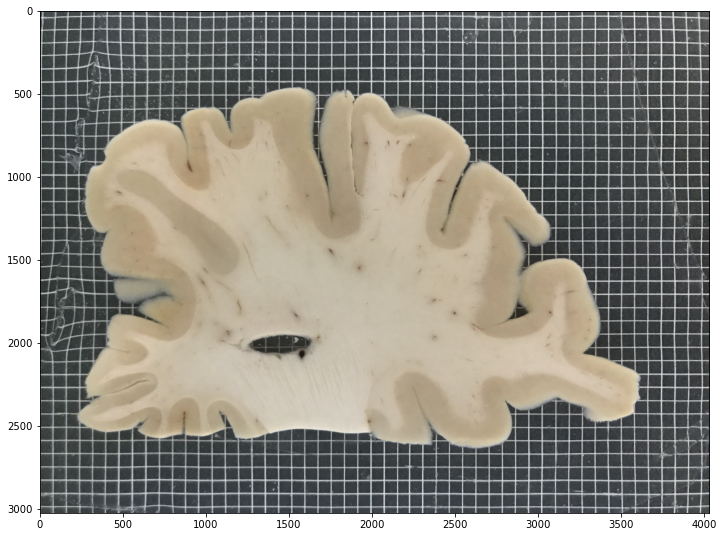

In [5]:
def get_photo(dandiset, subject, session):
    metadata = list_directory(dandiset,  f"sub-{subject}/ses-{session}/microscopy")
    # example:
    # sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_photo.jpg
    pattern = r"sub-(?P<subject>[^_]+)_ses-(?P<session>[^_]+)_run-(?P<run>[^_]+)_sample-(?P<sample>[^_]+)_photo.jpg"
    for filename, file_metadata in metadata["files"].items():
        match = re.match(pattern, filename)
        if match:
            url = get_asset_url(dandiset, file_metadata["asset_id"])
            req = requests.get(url, headers={"accept": "image/jpeg"})
            i = Image.open(BytesIO(req.content))
            return np.asarray(i)

subject =  "MITU01"
session = '20210820h19m29s49'
photo = get_photo("000108",subject, session)
pyplot.figure(figsize=(12, 12))
pyplot.imshow(photo)

## Reading a stitched volume

The following notebook cells read arbitrary volumes from a particular sample / stain.

We collect the relevant chunks for a sample and stain, then we find the extents of
each chunk, then find the ones that overlap and then we can read the parts of the
chunk that fall inside the requested volume and stitch them.

In [6]:
CHUNKDB = {}

def find_volume_chunks(dandiset, subject, sample, stain):
    """
    Find all the chunks needed to construct or sample from
    a volume from a given sample (a slab of tissue) and stain.
    
    :param dandiset: The name of the dandiset, e.g. "000108"
    :param subject: The name of the subject e.g. "MITU01"
    :param sample: The name of the slab we are trying to find
    :param stain: The name of the stain, e.g. "YO", "NN" or "LEC"
    """
    key  = (dandiset, subject, sample, stain)
    if key not in CHUNKDB:
        for session in find_all_sessions(dandiset, subject):
            try:
                all_chunks = find_all_chunks(dandiset, subject, session)
            except MissingSidecarError:
                # Need to debug this - the sidecar is available locally but not in Dandi
                continue
            for csample, cstain in all_chunks:
                if csample == sample and cstain == stain:
                    CHUNKDB[key] = all_chunks[sample, stain]
                    return all_chunks[sample, stain]
    else:
        return CHUNKDB[key]

chunks_41 = find_volume_chunks("000108", "MITU01", "41", "YO")
chunks_41

[{'asset_id': '56084f04-ad42-494f-bf0e-33a682ee6b3b',
  'path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-1_spim.h5',
  'sidecar_asset_id': 'e0c88e64-9927-4ff6-967b-ae3fb4828638',
  'sidecar_path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-1_spim.json'},
 {'asset_id': 'bd22a3d6-ab89-425a-bbc3-0db8168f0026',
  'path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-2_spim.h5',
  'sidecar_asset_id': 'f40d531e-350c-4ebc-9c6e-27fa2d0e6e40',
  'sidecar_path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-2_spim.json'},
 {'asset_id': '0eb86161-0bb2-42c7-b508-0df68ecb0baf',
  'path': 'sub-MITU01/ses-20210820h19m29s49/microscopy/sub-MITU01_ses-20210820h19m29s49_run-1_sample-41_stain-YO_chunk-3_spim.h5',
  'sidecar_asset_id': '01f90582-e68d-

In [7]:
# This is what our sidecar looks like - we're going to use
# the pixel size and pieces of the chunk transform matrix.

meta = get_json(get_asset_url("000108", chunks_41[0]["sidecar_asset_id"]))
meta

{'PixelSize': [2.564, 3.625, 2.564],
 'FieldOfView': [93729.584, 7424.0, 5251.072],
 'BodyPart': 'BRAIN',
 'BodyPartDetails': 'Entire brain',
 'BodyPartDetailsOntology': 'SNOMED',
 'Environment': 'exvivo',
 'SampleEmbedding': 'Elastic, exandable polyacrylamide hydrogel',
 'SampleFixation': 'PFA fixation followed by polyepoxy crosslinking',
 'Pathology': 'no pathology',
 'SampleExtractionProtocol': 'autopsy',
 'SampleExtractionInstitution': 'Massachusetts General Hospital',
 'SampleStaining': 'YO',
 'InstitutionName': 'MIT',
 'InstitutionAddress': '43 Vassar St, Cambridge, Ma.',
 'InstitutionalDepartmentName': 'Kwanghun Chung Lab',
 'ChunkTransformMatrixAxis': ['X', 'Y', 'Z'],
 'ChunkTransformMatrix': [[2.564, 0.0, 0.0, 0.0],
  [0.0, 3.625, 0.0, 0.0],
  [0.0, 0.0, 2.564, 0.0],
  [0.0, 0.0, 0.0, 1.0]],
 'PixelSizeUnits': 'um',
 'StationName': 'oSPIM1',
 'Immersion': 'ExPROTOS',
 'Magnification': '2x',
 'NumericalAperture': '0.1',
 'SliceThickness': '1000'}

In [8]:
class Volume:
    """
    This is a chunk record + the chunk's bounds
    
    There are methods for reading the chunk data in global
    coordinates and some methods that are needed for computing
    the cosine blending.
    """
    
    def __init__(self, rec, x0, x1, y0, y1, z0, z1, level):
        """
        :param rec: a record detailing where to get the asset ids and such
        :param x0: the minimum coordinate of the chunk in the x direction in global coordinates (divided by 2**level if level > 0)
        :param x1: the maximum coordinate of the chunk in the x direction in global coordinates
        :param y0: the minimum coordinate of the chunk in the y direction in global coordinates
        :param y1: the maximum coordinate of the chunk in the y direction in global coordinates
        :param z0: the minimum coordinate of the chunk in the z direction in global coordinates
        :param z1: the maximum coordinate of the chunk in the z direction in global coordinates
        """
        self.rec = rec
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1
        self.z0 = z0
        self.z1 = z1
        self.level = level
        
    def overlaps(self, x0, x1, y0, y1, z0, z1):
        """
        Return True if the given global coordinates overlap the chunk to some degree
        """
        return x1 > self.x0 and self.x1 > x0 and y1 > self.y0 and self.y1 > y0 and z1 > self.z0 and self.z1 > z0
    
    def read_block(self, dandiset, x0, x1, y0, y1, z0, z1):
        """
        Read the block indicated. For areas outside of the overlap, return an
        intensity of zero.
        """
        x0a = int(max(x0, self.x0))
        x1a = int(min(x1, self.x1))
        y0a = int(max(y0, self.y0))
        y1a = int(min(y1, self.y1))
        z0a = int(max(z0, self.z0))
        z1a = int(min(z1, self.z1))
        result = np.zeros((z1 - z0, y1 - y0, x1 - x0), np.uint16)
        asset_id = self.rec["asset_id"]
        url = get_asset_url(dandiset, asset_id)
        with h5py.File(url, "r", driver="ros3") as fd:
            block = fd[str(self.level)]
            result[z0a - z0:z1a - z0, y0a - y0:y1a - y0, x0a - x0:x1a - x0] = \
                block[0, 0, z0a - self.z0:z1a - self.z0, y0a - self.y0:y1a - self.y0, x0a - self.x0:x1a - self.x0]
        return result
    
    @property
    def x_extent(self):
        return self.x1 - self.x0
    
    @property
    def y_extent(self):
        return self.y1 - self.y0
    
    @property
    def z_extent(self):
        return self.z1 - self.z0

    def distance_to_edge(self, x0: int, x1: int, y0: int, y1: int,
                         z0: int, z1: int)\
            -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get the distance to the nearest edge for every voxel in the block
        defined by x0:x1, y0:y1, z0:z1. Points outside of the volume are marked
        with negative distance.

        :param x0: the starting x, in global coordinates
        :param x1: the ending x, in global coordinates
        :param y0: the starting y, in global coordinates
        :param y1: the ending y, in global coordinates
        :param z0: the starting z, in global coordinates
        :param z1: the ending z in global coordinates
        :return: the distance to the nearest edge for every voxel in the block
        for the z, y and x directions
        """
        z, y, x = np.mgrid[
                  z0-self.z0:z1-self.z0,
                  y0-self.y0:y1-self.y0,
                  x0-self.x0:x1-self.x0]
        to_x0 = x
        to_x1 = self.x_extent - x
        to_x = np.maximum(0, np.minimum(to_x0, to_x1))
        to_y0 = y
        to_y1 = self.y_extent - y
        to_y = np.maximum(0, np.minimum(to_y0, to_y1))
        to_z0 = z
        to_z1 = self.z_extent - z
        to_z = np.maximum(0, np.minimum(to_z0, to_z1))
        mask = (x >= 0) & (x < self.x_extent) &\
               (y >= 0) & (y < self.y_extent) &\
               (z >= 0) & (z < self.z_extent)
        to_x[~ mask] = -1
        to_y[~ mask] = -1
        to_z[~ mask] = -1
        return to_z, to_y, to_x
        
def read(dandiset, subject, sample, stain, x0, x1, y0, y1, z0, z1, level=0):
    """
    Read a subvolume and return as a Numpy array.
    :param dandiset: the name of the dandiset, e.g. "000108"
    :param subject: the subject from which the material was derived, e.g. "MITU01"
    :param session: the microscopy session for the volume, e.g. "20210521h17m17s06"
    :param sample: the sample name, e.g. "178"
    :param stain: the stain name, e.g. "YO", "NN" or "LEC"
    :param x0: The x-minimum coordinate of the volume. If level > 0,
               this should be (x0 of the original volume) / (2 ** level),
               in other words, the x0 of the downsampled volume
    :param x1: The x-maximum coordinate of the volume
    :param y0: The y-minimum coordinate of the volume
    :param y1: The y-maximum coordinate of the volume
    :param z0: The z-minimum coordinate of the volume
    :param z1: The z-maximum coordinate of the volume
    """
    chunkdb = find_volume_chunks(dandiset, subject, sample, stain)
    volumes = []
    #
    # Collect the blocks that overlap
    #
    for rec in chunkdb:
        volume = chunk_coords(dandiset, rec, level)
        if volume.overlaps(x0, x1, y0, y1, z0, z1):
            volumes.append(volume)

    if len(volumes) == 0:
        # Nothing overlaps
        return np.zeros((z1-z0, y1-y0, x1-x0), np.uint16)
    
    elif len(volumes) == 1:
        # One block overlaps
        return volumes[0].read_block(dandiset, x0, x1, y0, y1, z0, z1)
    else:
        block = np.zeros((z1-z0, y1-y0, x1-x0), np.float32)
        distances = [volume.distance_to_edge(x0, x1, y0, y1, z0, z1)
                     for volume in volumes]
        masks = [((dz >= 0) | (dy >= 0) | (dx >= 0)) for dz, dy, dx in distances]
        total = np.zeros(block.shape, np.float32)
        #
        # Compute the cosine blending in overlapping regions. The idea here
        # is to taper the intensity of an image as it approaches the image
        # edge, relative to the other overlapping image
        #
        for volume, (dz, dy, dx), mask in zip(volumes, distances, masks):
            vblock = volume.read_block(dandiset, x0, x1, y0, y1, z0, z1)
            fraction = mask.astype(float)
            for idx in [_ for _ in range(len(volumes))
                        if volumes[_].rec["path"] != volume.rec["path"]]:
                other = volumes[idx]
                other_mask = masks[idx]
                both_mask = mask & other_mask
                other_dz, other_dy, other_dx = distances[idx]
                distance = 100000000 * np.ones(dx.shape, np.float32)
                other_distance = 100000000 * np.ones(other_dx.shape, np.float32)
                if np.any(dx[both_mask] != other_dx[both_mask]):
                    distance = dx
                    other_distance = other_dx
                if np.any(dy[both_mask] != other_dy[both_mask]):
                    distance = np.minimum(distance, dy)
                    other_distance = np.minimum(other_distance, other_dy)
                if np.any(dz[both_mask] != other_dz[both_mask]):
                    distance = np.minimum(distance, dz)
                    other_distance = np.minimum(other_distance, other_dz)
                angle = np.arctan2(distance[both_mask],
                                   other_distance[both_mask])
                blending = np.sin(angle) ** 2
                fraction[both_mask] *= blending
            total += fraction
            block += (fraction * vblock).astype(block.dtype)
        return block / (total + np.finfo(np.float32).eps)


def chunk_coords(dandiset, rec, level):
    """
    Get the coordinates of a chunk relative to the slab
    
    Coordinates are returned as (z0, z1), (y0, y1), (x0, x1)
    """
    data = get_json(get_asset_url(dandiset, rec["sidecar_asset_id"]))
    lpower = 2 ** level
    x_extent, y_extent, z_extent = [int(np.round(b / a)) // lpower for a, b in zip(data["PixelSize"], data["FieldOfView"])]
    #
    # There's a shortcut here - the affine matrix is always just a transposition
    # and the transposition part is just the last element of the row.
    #
    matrix = data["ChunkTransformMatrix"]
    axes = data["ChunkTransformMatrixAxis"]
    pixel_size = data["PixelSize"]
    x_idx, y_idx, z_idx = [axes.index(_) for _ in ("X", "Y", "Z")]
    x0, y0, z0 = [int(matrix[idx][-1] / lpower / um) for idx, um in zip((x_idx, y_idx, z_idx), pixel_size)]
    return Volume(rec, x0, x0+x_extent, y0, y0+y_extent, z0, z0+z_extent, level)
    

In [9]:
def find_extents(dandiset, subject, sample, stain, level=0):
    min_x = min_y = min_z = np.inf
    max_x = max_y = max_z = 0
    for rec in find_volume_chunks(dandiset, subject, sample, stain):
        volume = chunk_coords(dandiset, rec, level)
        min_x, min_y, min_z = [min(a, b) for a, b in ((min_x, volume.x0), (min_y, volume.y0), (min_z, volume.z0))]
        max_x, max_y, max_z = [max(a, b) for a, b in ((max_x, volume.x1), (max_y, volume.y1), (max_z, volume.z1))]
    return dict(x0=min_x, x1=max_x, y0=min_y, y1=max_y, z0=min_z, z1=max_z)
[find_extents("000108", "MITU01", "41", "YO", level) for level in range(0, 7)]

[{'x0': 0, 'x1': 36556, 'y0': 0, 'y1': 16730, 'z0': 0, 'z1': 2048},
 {'x0': 0, 'x1': 18278, 'y0': 0, 'y1': 8365, 'z0': 0, 'z1': 1024},
 {'x0': 0, 'x1': 9139, 'y0': 0, 'y1': 4182, 'z0': 0, 'z1': 512},
 {'x0': 0, 'x1': 4569, 'y0': 0, 'y1': 2091, 'z0': 0, 'z1': 256},
 {'x0': 0, 'x1': 2284, 'y0': 0, 'y1': 1045, 'z0': 0, 'z1': 128},
 {'x0': 0, 'x1': 1142, 'y0': 0, 'y1': 522, 'z0': 0, 'z1': 64},
 {'x0': 0, 'x1': 571, 'y0': 0, 'y1': 261, 'z0': 0, 'z1': 32}]

In [10]:
level = 6
extents6 = find_extents("000108", "MITU01", "41", "YO", level)
overview = read("000108", "MITU01", "41", "YO", 0, extents6["x1"], 0, extents6["y1"], 0, extents6["z1"], level)

In [11]:
overview.shape

(32, 261, 571)

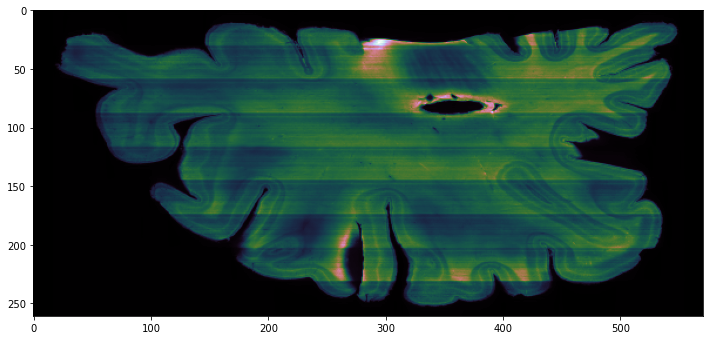

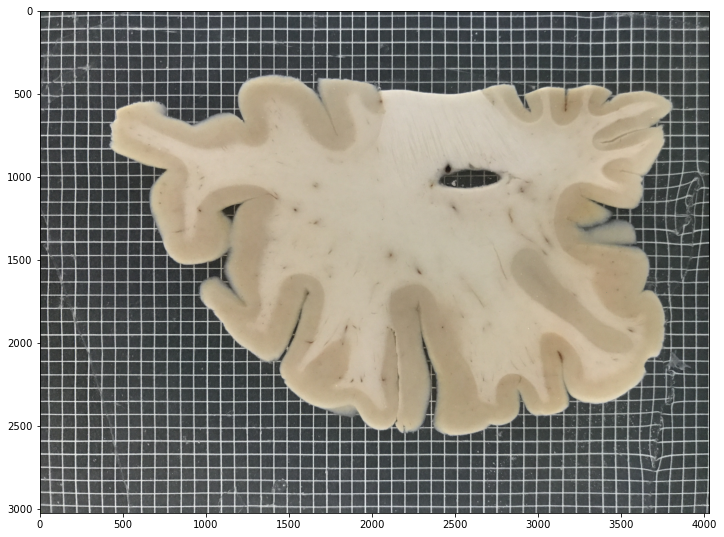

In [12]:
pyplot.figure(figsize=(12, 12))
pyplot.imshow(overview[16, :], cmap='cubehelix')
pyplot.figure(figsize=(12, 12))
pyplot.imshow(photo[::-1, ::-1])

### Use neuroglancer to display the stitched volume

In [13]:
import neuroglancer
import os

In [14]:
viewer = neuroglancer.Viewer()

In [15]:
# This volume handle can be used to notify the viewer that the data has changed.
volume = neuroglancer.LocalVolume(
    overview,
    dimensions=neuroglancer.CoordinateSpace(
        names=['x', 'y', 'z'],
        units=['um', 'um', 'um'],
        scales=[val*level for val in meta["PixelSize"]],
    ),
    voxel_offset=[0,0,0]
    )
with viewer.txn() as s:
    s.layers['volume'] = neuroglancer.ImageLayer(
        source=volume,
        # Define a custom shader to display this mask array as red+alpha.
        shader="""
#uicontrol vec3 color color(default="green")
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-9, max=-5, step=0.1)
void main() {
  emitRGB(color *
          (toNormalized(getDataValue(0)) + brightness) *
          exp(contrast));
}
""",
    )
    s.position = np.array(overview.shape)/2
print("Neuroglancer URL:", viewer.get_viewer_url().replace("http://127.0.0.1:", f"https://hub.dandiarchive.org/user/{os.environ['GITHUB_USER']}/proxy/"))

Neuroglancer URL: https://hub.dandiarchive.org/user/satra/proxy/41511/v/19ce6d52b2adb874bb139eb855f64eda1c6f735e/


In [16]:
# This is approximately at the stitching between chunks 1 and 2
x, y, z = 16080, 1957, 1024
img = read("000108", "MITU01", "41", "YO", x-200, x+200, y-200, y+200, z, z+1)[0]

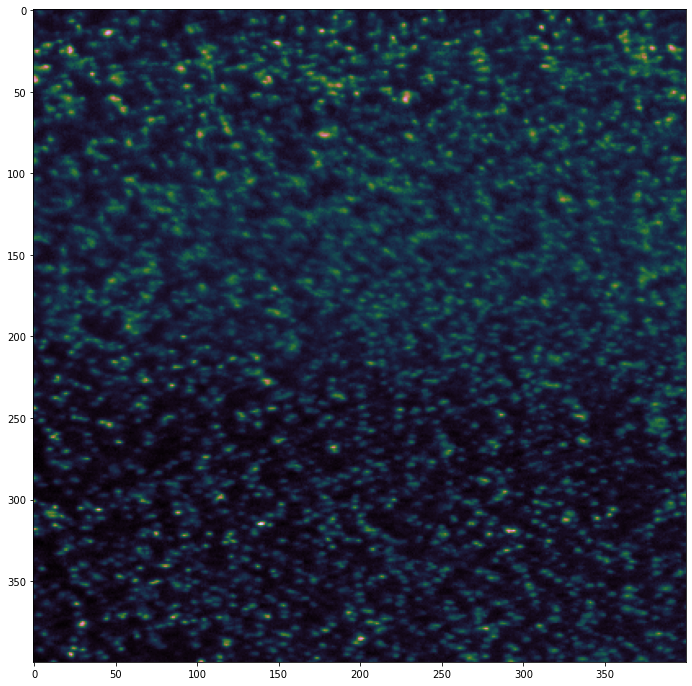

In [17]:
pyplot.figure(figsize=(12, 12))
pyplot.imshow(img, cmap='cubehelix')

## Demo of a simple blood vessel segmentation

Get a portion of the Lectin channel which stains blood vessels. Compute vesselness
on the block to enhance it and then threshold it to segment the blood vessels

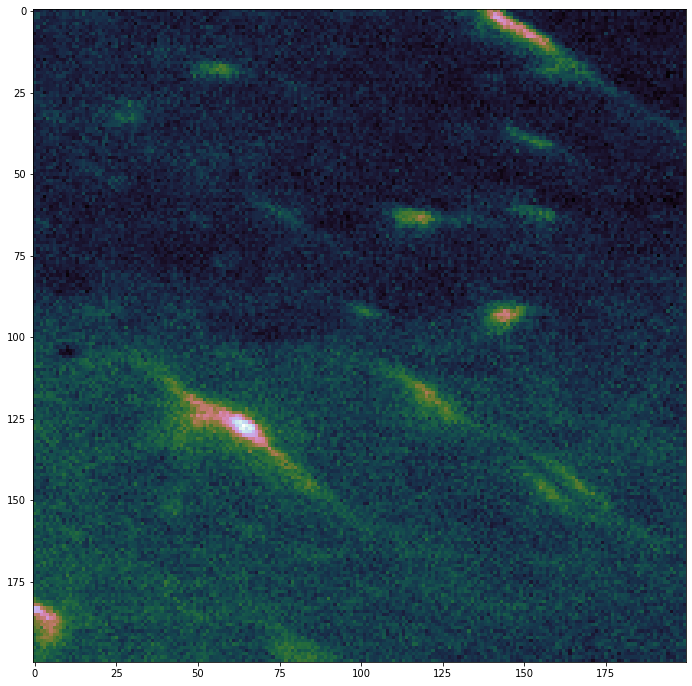

In [18]:
block_LEC = read("000108", "MITU01", "41", "LEC", 19506, 19706, 8549, 8749, 1000, 1064)
pyplot.figure(figsize=(12, 12))
pyplot.imshow(block_LEC[32], cmap='cubehelix')

In [19]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
hm = hessian_matrix(block_LEC, sigma=2)

In [20]:
evs = hessian_matrix_eigvals(hm)

In [21]:
def vesselness(evs, a1=.5, a2=2):
    """
    From https://mevislabdownloads.mevis.de/docs/current/FMEstable/ReleaseMeVis/Documentation/Publish/ModuleReference/Vesselness.html
    https://hal.archives-ouvertes.fr/hal-02544493/file/Lamy_ICPR_2020.pdf
    
    """
    mask0 = evs[1] >= 0
    mask1 = (~ mask0) & (evs[2] < 0)
    mask2 = (~ mask0) & (~ mask1)
    result = np.zeros_like(evs[0])
    result[mask1] = -evs[1, mask1] * np.exp(-np.square(evs[0, mask1]) / (2 * np.square(a1 * evs[1, mask1])))
    result[mask2] = -evs[1, mask2] * np.exp(-np.square(evs[0, mask2]) / (2 * np.square(a2 * evs[1, mask2])))
    return result
ves = vesselness(evs)

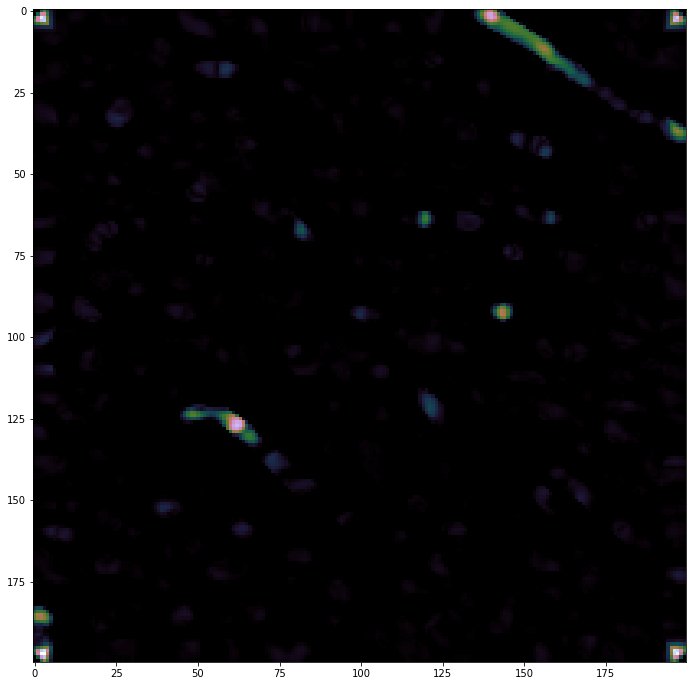

In [22]:
pyplot.figure(figsize=(12, 12))
pyplot.imshow(ves[35], cmap='cubehelix')

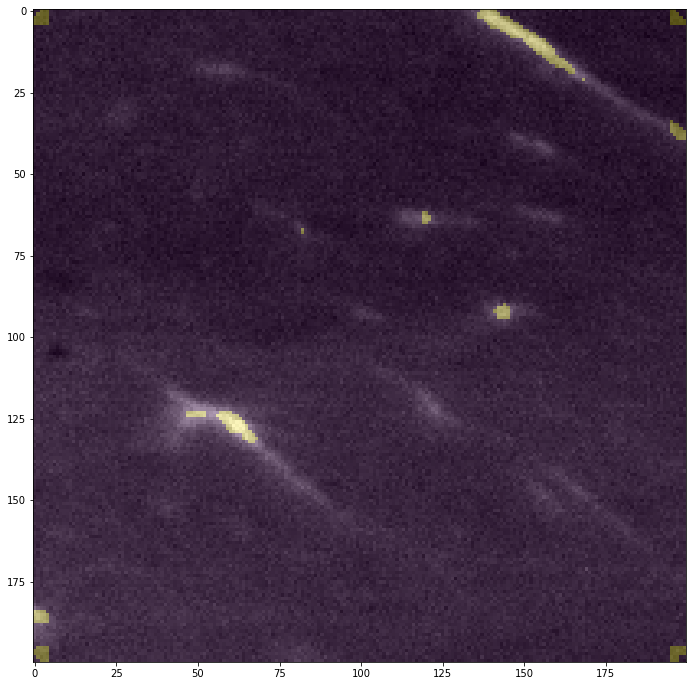

In [23]:
from skimage.filters import threshold_otsu
seg = ves > threshold_otsu(ves)
pyplot.figure(figsize=(12, 12))
pyplot.imshow(block_LEC[35], cmap='gray')
pyplot.imshow(seg[35], alpha=.3)